# Momentum

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
import re
import datetime
%matplotlib inline

In [2]:
train = pd.read_csv('../data/train_team.csv')
test = pd.read_csv('../data/test_team.csv')

In [3]:
train.head()

,game_date,home_team,away_team,home_score,away_score,tournament,country,neutral,overall_diff,attack_away_defence_home_diff,...,bup_speed_diff,cc_crossing_diff,cc_passing_diff,cc_shooting_diff,d_aggresion_diff,d_pressure_diff,d_width_diff,home_win,x_rating,y_rating
0,2006-09-01 00:00:00+00:00,Denmark,Portugal,4,2,Friendly,Denmark,False,-3.0,3.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1,78.0,81.0
1,2006-10-11 00:00:00+00:00,Poland,Portugal,2,1,UEFA Euro qualification,Poland,False,-7.0,10.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1,74.0,81.0
2,2006-09-06 00:00:00+00:00,Finland,Portugal,1,1,UEFA Euro qualification,Finland,False,-7.0,9.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0,74.0,81.0
3,2006-10-07 00:00:00+00:00,Denmark,Northern Ireland,0,0,UEFA Euro qualification,Denmark,False,9.0,-11.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0,78.0,69.0
4,2006-10-11 00:00:00+00:00,Austria,Switzerland,2,1,Friendly,Austria,False,-3.0,4.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1,73.0,76.0


In [4]:
train.columns

Index(['game_date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'country', 'neutral', 'overall_diff',
       'attack_away_defence_home_diff', 'attack_diff',
       'attack_home_defence_away_diff', 'defence_diff', 'midfield_diff',
       'rank_diff', 'prestige_diff', 'growth_diff', 'full_age_diff',
       'start_age_diff', 'value_euros_millions_diff',
       'wage_euros_thousands_diff', 'goalkeeper_overall_diff',
       'bup_dribbling_diff', 'bup_passing_diff', 'bup_speed_diff',
       'cc_crossing_diff', 'cc_passing_diff', 'cc_shooting_diff',
       'd_aggresion_diff', 'd_pressure_diff', 'd_width_diff', 'home_win',
       'x_rating', 'y_rating'],
      dtype='object')

We first need to see for matches that are not neutral (i.e. home team is actually playing at home), if playing at home actually is an advantage. 

In [5]:
#First make sure there are no "away" teams in own country.
train[train['away_team'] == train['country']]

,game_date,home_team,away_team,home_score,away_score,tournament,country,neutral,overall_diff,attack_away_defence_home_diff,...,bup_speed_diff,cc_crossing_diff,cc_passing_diff,cc_shooting_diff,d_aggresion_diff,d_pressure_diff,d_width_diff,home_win,x_rating,y_rating


In [6]:
print("Proportion of Outcomes")
train.groupby('home_win')['game_date'].count() / len(train)

Proportion of Outcomes


home_win
-1    0.301529
 0    0.260411
 1    0.438060
Name: game_date, dtype: float64

In [7]:
print("Proportion of Outcomes Grouped By Neutrality")
train.groupby(['neutral', 'home_win'])['game_date'].count() / train.groupby(['neutral'])['game_date'].count()

Proportion of Outcomes Grouped By Neutrality


neutral  home_win
False    -1          0.284536
          0          0.270103
          1          0.445361
True     -1          0.357466
          0          0.228507
          1          0.414027
Name: game_date, dtype: float64

Surprisingly, it seems that being at home actually does not give an advantage! 

From the European matches we saw that past match results might be good features. As such, we do the same thing here and calculate the number of wins by the home team and away team and the past matches. 


In [8]:
train_sorted = train.sort_values(by = 'game_date').reset_index(drop = True)

In [9]:
train_sorted.head()

,game_date,home_team,away_team,home_score,away_score,tournament,country,neutral,overall_diff,attack_away_defence_home_diff,...,bup_speed_diff,cc_crossing_diff,cc_passing_diff,cc_shooting_diff,d_aggresion_diff,d_pressure_diff,d_width_diff,home_win,x_rating,y_rating
0,2006-09-01 00:00:00+00:00,Denmark,Portugal,4,2,Friendly,Denmark,False,-3.0,3.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1,78.0,81.0
1,2006-09-02 00:00:00+00:00,Romania,Bulgaria,2,2,UEFA Euro qualification,Romania,False,-1.0,2.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0,73.0,74.0
2,2006-09-02 00:00:00+00:00,Poland,Finland,1,3,UEFA Euro qualification,Poland,False,-0.0,4.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-1,74.0,74.0
3,2006-09-02 00:00:00+00:00,Hungary,Norway,1,4,UEFA Euro qualification,Hungary,False,-7.0,7.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-1,68.0,75.0
4,2006-09-02 00:00:00+00:00,Germany,Ireland,1,0,UEFA Euro qualification,Germany,False,8.0,-8.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1,84.0,76.0


In [10]:
def get_wins_in_last_matches(df_row, df, num_games, team_id_col = ['home_team', 'away_team'],
                            against_each_other = False):
    """
    Get number of wins for home team and away team as well as win and lose momentum for num_games before current game. Also includes 
    indicators of whether the team has played enough games (for the matches in the beginning). If against_each_other
    is True, get number of wins home team has against away team had in past num_games.
    
    """

    home_team_id_colname = team_id_col[0]
    away_team_id_colname = team_id_col[1]

    if not against_each_other:

        #Get past games for both home and away teams.
        home_past_games = df[((df[home_team_id_colname] == df_row[home_team_id_colname])\
                            | (df[away_team_id_colname] == df_row[home_team_id_colname]))\
                             & (df.game_date < df_row.game_date)][-num_games:]
        away_past_games = df[((df[home_team_id_colname]== df_row[away_team_id_colname])\
                            | (df[away_team_id_colname] == df_row[away_team_id_colname]))\
                             & (df.game_date < df_row.game_date)][-num_games:]        
       
        
        #get number of wins for home team 
        home_wins = 0
        home_win_momentum = 0
        home_lose_momentum = 0
        for index, game in home_past_games.iterrows():
            if game[home_team_id_colname] == df_row[home_team_id_colname]:
                if game.home_win == 1:
                    home_wins += 1
                    home_win_momentum += df_row['y_rating']/100
                else:
                    home_lose_momentum -= (1-df_row['y_rating']/100)
            elif game[away_team_id_colname] == df_row[home_team_id_colname]:
                if game.home_win == 0:
                    home_wins += 1
                    home_win_momentum += df_row['x_rating']/100
                else:
                    home_lose_momentum -= (1-df_row['x_rating']/100)

        

        #get number of wins for away team         
        away_wins = 0
        away_win_momentum = 0
        away_lose_momentum = 0
        for index, game in away_past_games.iterrows():

            if game[home_team_id_colname] == df_row[away_team_id_colname]:
                if game.home_win == 1:
                    away_wins += 1
                    away_win_momentum += df_row['y_rating']/100
                else:
                    away_lose_momentum -= (1-df_row['y_rating']/100)
            elif game[away_team_id_colname] == df_row[away_team_id_colname]:
                if game.home_win == 0:
                    away_wins += 1
                    away_win_momentum += df_row['x_rating']/100
                else:
                    away_lose_momentum -= (1-df_row['x_rating']/100)

                
        if len(home_past_games) != 0:
            home_wins = home_wins / len(home_past_games)
        if len(away_past_games) != 0:
            away_wins = away_wins / len(away_past_games)
        return (home_wins, away_wins,home_win_momentum,home_lose_momentum,away_win_momentum,away_lose_momentum)
#         return (home_wins, away_wins, len(home_past_games), len(away_past_games))
    else:
        #get past games where the two teams played against each other
        past_games = df[(((df[home_team_id_colname] == df_row[home_team_id_colname])\
                            & (df[away_team_id_colname] == df_row[away_team_id_colname]))\
                        | ((df[home_team_id_colname] == df_row[away_team_id_colname])
                        & (df[away_team_id_colname] == df_row[home_team_id_colname])))
                        & (df.game_date < df_row.game_date)][-num_games:]
        wins = 0
        for index, game in past_games.iterrows():
            #home team wins in past game against away team as home team
            if game[home_team_id_colname] == df_row[home_team_id_colname] and game.home_win == 1:
                wins += 1
            #home team wins in past game against away team as away team
            elif game[away_team_id_colname] == df_row[home_team_id_colname] and game.home_win == 0:
                wins += 1
        if len(past_games) != 0:
            wins = wins / len(past_games)
        return (wins)
#         return (wins, len(past_games))

In [11]:
wins_past_x_games = {}
win_momentum_past_x_games = {}
lose_momentum_past_x_games = {}
for index, row in train_sorted.iterrows():
    for i in range(1, 6):
        if i not in wins_past_x_games.keys():
            wins_past_x_games[i] = []
            win_momentum_past_x_games[i] = []
            lose_momentum_past_x_games[i] = []            
        # results = (home_wins, away_wins,home_win_momentum,home_lose_momentum,away_win_momentum,away_lose_momentum)
        results = get_wins_in_last_matches(row, train_sorted, i)

        # these stats are saved in (home,away) format
        wins_past_x_games[i].append((results[0],results[1]))
        win_momentum_past_x_games[i].append((results[2],results[4]))
        lose_momentum_past_x_games[i].append((results[3],results[5]))

In [12]:
wins_past_x_games_df = pd.DataFrame(index = train_sorted.index)
for i in range(1, 6):
    wins_past_x_games_df = wins_past_x_games_df.merge(
            pd.DataFrame(wins_past_x_games[i], index = train_sorted.index,\
             columns = ['home_wins_past_{}_games'.format(i), 'away_wins_past_{}_games'.format(i)]), \
                        left_index = True, right_index = True)
    wins_past_x_games_df = wins_past_x_games_df.merge(
            pd.DataFrame(win_momentum_past_x_games[i], index = train_sorted.index,\
             columns = ['home_win_momentum_past_{}_games'.format(i), 'away_win_momentum_past_{}_games'.format(i)]), \
                        left_index = True, right_index = True)

    wins_past_x_games_df = wins_past_x_games_df.merge(
            pd.DataFrame(lose_momentum_past_x_games[i], index = train_sorted.index,\
             columns = ['home_lose_momentum_past_{}_games'.format(i), 'away_lose_momentum_past_{}_games'.format(i)]), \
                        left_index = True, right_index = True)
    
    

In [13]:
wins_past_x_games_df.tail()

,home_wins_past_1_games,away_wins_past_1_games,home_win_momentum_past_1_games,away_win_momentum_past_1_games,home_lose_momentum_past_1_games,away_lose_momentum_past_1_games,home_wins_past_2_games,away_wins_past_2_games,home_win_momentum_past_2_games,away_win_momentum_past_2_games,...,home_win_momentum_past_4_games,away_win_momentum_past_4_games,home_lose_momentum_past_4_games,away_lose_momentum_past_4_games,home_wins_past_5_games,away_wins_past_5_games,home_win_momentum_past_5_games,away_win_momentum_past_5_games,home_lose_momentum_past_5_games,away_lose_momentum_past_5_games
1892,1.0,0.0,0.73,0.0,0.00,-0.14,1.0,0.5,1.46,0.86,...,1.46,2.32,-0.41,-0.14,0.4,0.8,1.46,3.18,-0.55,-0.14
1893,1.0,0.0,0.85,0.0,0.00,-0.23,1.0,0.0,1.70,0.00,...,3.40,0.77,0.00,-0.69,1.0,0.4,4.25,1.62,0.00,-0.69
1894,0.0,0.0,0.00,0.0,-0.24,-0.27,0.0,0.0,0.00,0.00,...,0.00,0.00,-1.02,-0.27,0.0,0.0,0.00,0.00,-1.26,-0.27
1895,1.0,0.0,0.73,0.0,0.00,-0.16,0.5,0.5,0.73,0.73,...,1.46,0.73,-0.54,-0.16,0.4,0.5,1.46,0.73,-0.70,-0.16
1896,0.0,0.0,0.00,0.0,-0.25,-0.25,0.0,0.0,0.00,0.00,...,0.00,0.00,-0.25,-1.02,0.0,0.0,0.00,0.00,-0.25,-1.27


In [14]:
#against each other
wins_home_against_away_past_x_games = {}
for index, row in train_sorted.iterrows():
    for i in range(1, 6):
        if i not in wins_home_against_away_past_x_games.keys():
            wins_home_against_away_past_x_games[i] = []
        wins_home_against_away_past_x_games[i].append(get_wins_in_last_matches(row, train_sorted, i, 
                                                                                against_each_other=True))

In [15]:
wins_home_against_away_past_x_games_df = pd.DataFrame(index = train_sorted.index)
for i in range(1, 6):
    wins_home_against_away_past_x_games_df = wins_home_against_away_past_x_games_df.merge(
            pd.DataFrame(wins_home_against_away_past_x_games[i], index = train_sorted.index,\
            columns = ['wins_home_against_away_{}_games'.format(i)]),\
                        left_index = True, right_index = True)
#             columns = ['wins_home_against_away_{}_games'.format(i), 'num_past_games_{}'.format(i),]),\
#                         left_index = True, right_index = True)

In [16]:
wins_past_x_games_df.columns

Index(['home_wins_past_1_games', 'away_wins_past_1_games',
       'home_win_momentum_past_1_games', 'away_win_momentum_past_1_games',
       'home_lose_momentum_past_1_games', 'away_lose_momentum_past_1_games',
       'home_wins_past_2_games', 'away_wins_past_2_games',
       'home_win_momentum_past_2_games', 'away_win_momentum_past_2_games',
       'home_lose_momentum_past_2_games', 'away_lose_momentum_past_2_games',
       'home_wins_past_3_games', 'away_wins_past_3_games',
       'home_win_momentum_past_3_games', 'away_win_momentum_past_3_games',
       'home_lose_momentum_past_3_games', 'away_lose_momentum_past_3_games',
       'home_wins_past_4_games', 'away_wins_past_4_games',
       'home_win_momentum_past_4_games', 'away_win_momentum_past_4_games',
       'home_lose_momentum_past_4_games', 'away_lose_momentum_past_4_games',
       'home_wins_past_5_games', 'away_wins_past_5_games',
       'home_win_momentum_past_5_games', 'away_win_momentum_past_5_games',
       'home_lose_mome

In [17]:
past_wins_columns = []
for i in range(1, 6):
    wins_past_x_games_df['wins_past_{}_games_diff'.format(i)] =\
        (wins_past_x_games_df['home_wins_past_{}_games'.format(i)] -\
         wins_past_x_games_df['away_wins_past_{}_games'.format(i)])
    past_wins_columns.append('wins_past_{}_games_diff'.format(i))
    
    wins_past_x_games_df['win_momentum_past_{}_games_diff'.format(i)] =\
        (wins_past_x_games_df['home_win_momentum_past_{}_games'.format(i)] -\
         wins_past_x_games_df['away_win_momentum_past_{}_games'.format(i)])
    past_wins_columns.append('win_momentum_past_{}_games_diff'.format(i))   
    
    wins_past_x_games_df['lose_momentum_past_{}_games_diff'.format(i)] =\
        (wins_past_x_games_df['home_lose_momentum_past_{}_games'.format(i)] -\
         wins_past_x_games_df['away_lose_momentum_past_{}_games'.format(i)])
    past_wins_columns.append('lose_momentum_past_{}_games_diff'.format(i))       
    
#     past_wins_columns.append('home_num_past_games{}'.format(i))
    #games against each other
    wins_past_x_games_df['wins_home_against_away_{}_games'.format(i)] = \
                            wins_home_against_away_past_x_games_df['wins_home_against_away_{}_games'.format(i)]
    past_wins_columns.append('wins_home_against_away_{}_games'.format(i))



In [18]:
train_final = train_sorted.copy()
train_final[past_wins_columns] = wins_past_x_games_df[past_wins_columns]
train_final.tail()

,game_date,home_team,away_team,home_score,away_score,tournament,country,neutral,overall_diff,attack_away_defence_home_diff,...,lose_momentum_past_3_games_diff,wins_home_against_away_3_games,wins_past_4_games_diff,win_momentum_past_4_games_diff,lose_momentum_past_4_games_diff,wins_home_against_away_4_games,wins_past_5_games_diff,win_momentum_past_5_games_diff,lose_momentum_past_5_games_diff,wins_home_against_away_5_games
1892,2018-06-09 00:00:00+00:00,Tunisia,Spain,0,1,Friendly,Russia,True,-13.0,12.0,...,0.00,0.0,-0.25,-0.86,-0.27,0.0,-0.4,-1.72,-0.41,0.0
1893,2018-06-10 00:00:00+00:00,Austria,Brazil,0,3,Friendly,Austria,False,-8.0,11.0,...,0.69,0.0,0.75,2.63,0.69,0.0,0.6,2.63,0.69,0.0
1894,2018-06-11 00:00:00+00:00,Korea Republic,Senegal,0,2,Friendly,Austria,True,-3.0,7.0,...,-0.51,0.0,0.00,0.00,-0.75,0.0,0.0,0.00,-0.99,0.0
1895,2018-06-11 00:00:00+00:00,Belgium,Costa Rica,4,1,Friendly,Belgium,False,11.0,-16.0,...,-0.11,0.0,0.00,0.73,-0.38,0.0,-0.1,0.73,-0.54,0.0
1896,2018-06-12 00:00:00+00:00,Japan,Paraguay,4,2,Friendly,Austria,True,1.0,2.0,...,0.51,0.0,0.00,0.00,0.77,0.0,0.0,0.00,1.02,0.0


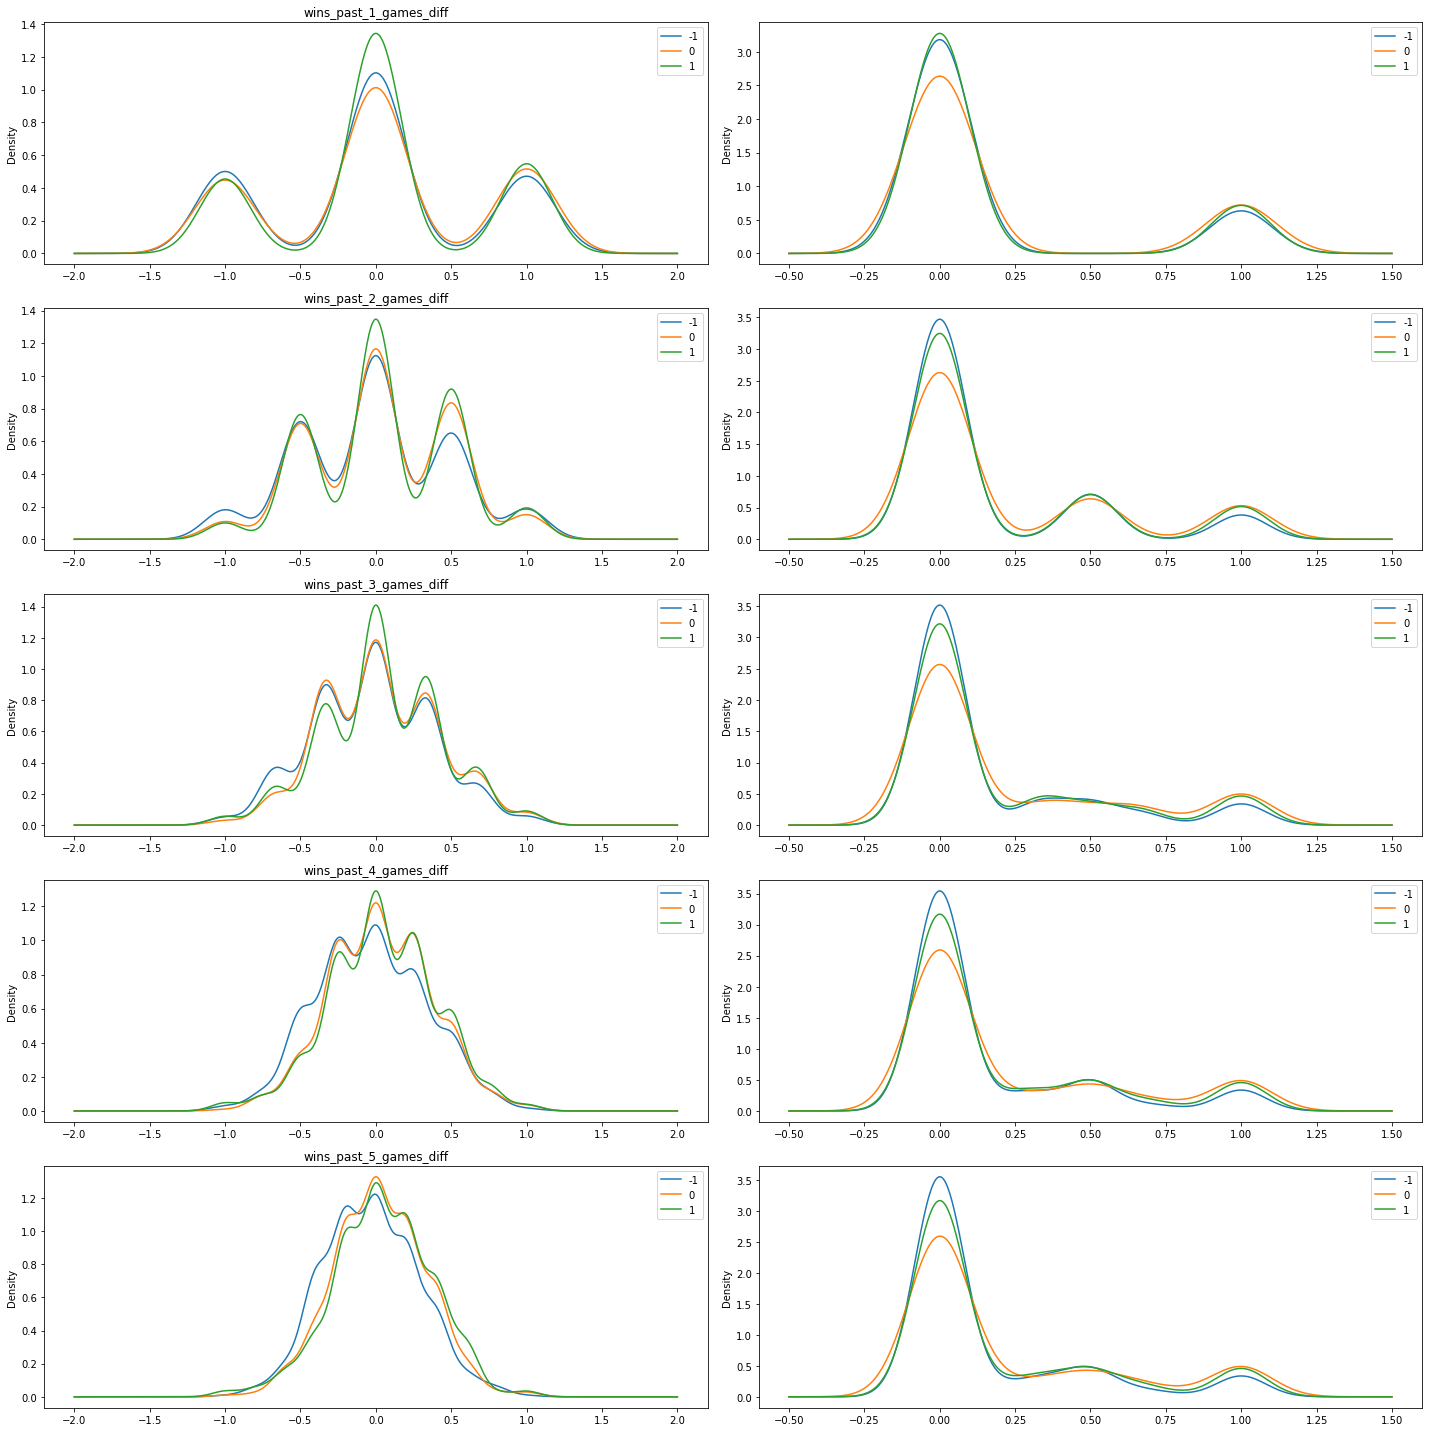

In [19]:
fig, axes = plt.subplots(5, 2, figsize = (20, 20))
axes = axes.flatten()

for label, df in train_final.groupby('home_win'):
    counter = 0
    for i, col in enumerate(past_wins_columns):
        if i % 4 == 1 or i % 4 == 2:
            continue
        df[col].plot.kde(label=label, ax = axes[counter])
        #odd plots are the plots of the teams against each other
        if i % 4 == 1:
            axes[counter].set_title(col + " (Past games of the home team against the away team)")
        elif i % 4 == 0:
            axes[counter].set_title(col)
        axes[counter].legend()
        counter += 1        

plt.tight_layout();

We realized that the test set is already sorted by earliest game in the tournament to latest game. Since we will not be using date for any of the features besides calculating past wins, we can just for the test set set each match to be one day after the other and it will not affect anything.

In [20]:
test['game_date'] = [datetime.datetime(2018,6, 14) + datetime.timedelta(days=i) for i in range(64)] 

In [21]:
#func12
wins_past_x_games = {}
win_momentum_past_x_games = {}
lose_momentum_past_x_games = {}

for index, row in test.iterrows():
    for i in range(1, 6):        
        if i not in wins_past_x_games.keys():
            wins_past_x_games[i] = []
            win_momentum_past_x_games[i] = []
            lose_momentum_past_x_games[i] = [] 
        results = get_wins_in_last_matches(row, test, i)
        
        
        # these stats are saved in (home,away) format
        wins_past_x_games[i].append((results[0],results[1]))
        win_momentum_past_x_games[i].append((results[2],results[4]))
        lose_momentum_past_x_games[i].append((results[3],results[5]))

In [22]:
# wins_past_x_games

In [23]:
wins_past_x_games_df = pd.DataFrame(index = test.index)
for i in range(1, 6):
    wins_past_x_games_df = wins_past_x_games_df.merge(
            pd.DataFrame(wins_past_x_games[i], index = test.index,\
             columns = ['home_wins_past_{}_games'.format(i), 'away_wins_past_{}_games'.format(i)]), \
                        left_index = True, right_index = True)
    
    wins_past_x_games_df = wins_past_x_games_df.merge(
            pd.DataFrame(win_momentum_past_x_games[i], index = test.index,\
             columns = ['home_win_momentum_past_{}_games'.format(i), 'away_win_momentum_past_{}_games'.format(i)]), \
                        left_index = True, right_index = True)

    wins_past_x_games_df = wins_past_x_games_df.merge(
            pd.DataFrame(lose_momentum_past_x_games[i], index = test.index,\
             columns = ['home_lose_momentum_past_{}_games'.format(i), 'away_lose_momentum_past_{}_games'.format(i)]), \
                        left_index = True, right_index = True)    

In [24]:
#against each other
wins_home_against_away_past_x_games = {}
for index, row in test.iterrows():
    for i in range(1, 6):
        if i not in wins_home_against_away_past_x_games.keys():
            wins_home_against_away_past_x_games[i] = []
        wins_home_against_away_past_x_games[i].append(get_wins_in_last_matches(row, test, i, 
                                                                                against_each_other=True))

In [25]:
wins_home_against_away_past_x_games_df = pd.DataFrame(index = test.index)
for i in range(1, 6):
    wins_home_against_away_past_x_games_df = wins_home_against_away_past_x_games_df.merge(
            pd.DataFrame(wins_home_against_away_past_x_games[i], index = test.index,\
#             columns = ['wins_home_against_away_{}_games'.format(i), 'num_past_games_{}'.format(i),]),\
#                         left_index = True, right_index = True)
            columns = ['wins_home_against_away_{}_games'.format(i)]),\
                        left_index = True, right_index = True)


In [26]:
past_wins_columns = []
for i in range(1, 6):
    wins_past_x_games_df['wins_past_{}_games_diff'.format(i)] =\
        (wins_past_x_games_df['home_wins_past_{}_games'.format(i)] -\
         wins_past_x_games_df['away_wins_past_{}_games'.format(i)])
    past_wins_columns.append('wins_past_{}_games_diff'.format(i))
    
    
    wins_past_x_games_df['win_momentum_past_{}_games_diff'.format(i)] =\
        (wins_past_x_games_df['home_win_momentum_past_{}_games'.format(i)] -\
         wins_past_x_games_df['away_win_momentum_past_{}_games'.format(i)])
    past_wins_columns.append('win_momentum_past_{}_games_diff'.format(i))   
    
    wins_past_x_games_df['lose_momentum_past_{}_games_diff'.format(i)] =\
        (wins_past_x_games_df['home_lose_momentum_past_{}_games'.format(i)] -\
         wins_past_x_games_df['away_lose_momentum_past_{}_games'.format(i)])
    past_wins_columns.append('lose_momentum_past_{}_games_diff'.format(i))       
        
#     past_wins_columns.append('home_num_past_games{}'.format(i))
    #games against each other
    wins_past_x_games_df['wins_home_against_away_{}_games'.format(i)] = \
                            wins_home_against_away_past_x_games_df['wins_home_against_away_{}_games'.format(i)]
    past_wins_columns.append('wins_home_against_away_{}_games'.format(i))


In [27]:
test_final = test.copy()
test_final[past_wins_columns] = wins_past_x_games_df[past_wins_columns]
test_final.tail()

,game_date,home_team,away_team,home_score,away_score,tournament,country,neutral,overall_diff,attack_away_defence_home_diff,...,lose_momentum_past_3_games_diff,wins_home_against_away_3_games,wins_past_4_games_diff,win_momentum_past_4_games_diff,lose_momentum_past_4_games_diff,wins_home_against_away_4_games,wins_past_5_games_diff,win_momentum_past_5_games_diff,lose_momentum_past_5_games_diff,wins_home_against_away_5_games
59,2018-08-12,Russia,Croatia,2,2,FIFA World Cup,Russia,False,-1.0,4.0,...,0.22,0.0,0.25,0.80,0.22,0.0,0.25,0.80,0.22,0.0
60,2018-08-13,France,Belgium,1,0,FIFA World Cup,Russia,True,2.0,4.0,...,0.15,0.0,0.25,0.85,0.15,0.0,0.20,0.85,0.15,0.0
61,2018-08-14,Croatia,England,2,1,FIFA World Cup,Russia,True,-1.0,5.0,...,0.19,0.0,0.00,0.00,-0.01,0.0,0.20,0.81,0.19,0.0
62,2018-08-15,Belgium,England,2,0,FIFA World Cup,Russia,True,2.0,0.0,...,0.17,0.0,0.25,0.81,0.19,0.0,0.20,0.81,0.19,0.0
63,2018-08-16,France,Croatia,4,2,FIFA World Cup,Russia,True,5.0,0.0,...,0.00,0.0,0.25,0.85,0.15,0.0,0.40,1.65,0.30,0.0


In [28]:
# test_final

In [29]:
def get_stats_in_last_matches(df_row, df, stat, num_games, team_id_col = ['home_team', 'away_team']):
    home_team_id_colname = team_id_col[0]
    away_team_id_colname = team_id_col[1]

    #Get past games for both home and away teams.
    home_past_games = df[((df[home_team_id_colname] == df_row[home_team_id_colname])\
                        | (df[away_team_id_colname] == df_row[home_team_id_colname]))\
                         & (df.game_date < df_row.game_date)][-num_games:]
    away_past_games = df[((df[home_team_id_colname]== df_row[away_team_id_colname])\
                        | (df[away_team_id_colname] == df_row[away_team_id_colname]))\
                         & (df.game_date < df_row.game_date)][-num_games:]
    

    home_stat_total = 0
    home_stat_against_total = 0
    away_stat_total = 0
    away_stat_against_total = 0


    for index, game in home_past_games.iterrows():
        #home team was still home team
        if game[home_team_id_colname] == df_row[home_team_id_colname]:
            home_stat_total += game['home_' + stat]
            home_stat_against_total += game['away_' + stat]
        #home team was away_team
        elif game[away_team_id_colname] == df_row[home_team_id_colname]:
            home_stat_total += game['away_' + stat]
            home_stat_against_total += game['home_' + stat]


    #get number of wins for away team         
    away_wins = 0
    for index, game in away_past_games.iterrows():
        if game[home_team_id_colname] == df_row[away_team_id_colname]:
            away_stat_total += game['home_' + stat]
            away_stat_against_total += game['away_' + stat]

        elif game[away_team_id_colname] == df_row[away_team_id_colname]:
            away_stat_total += game['away_' + stat]
            away_stat_against_total += game['home_' + stat]
    if len(home_past_games) != 0:
        home_stat_total = home_stat_total / len(home_past_games)
        home_stat_against_total = home_stat_against_total / len(home_past_games)
    if len(away_past_games) != 0:
        away_stat_total = away_stat_total / len(away_past_games)
        away_stat_against_total = away_stat_against_total / len(away_past_games)

    return (home_stat_total, home_stat_against_total, away_stat_total, away_stat_against_total)


def make_past_columns(df, stat, max_num_games, team_id_col = ['home_team', 'away_team']):
    past_x_games = {}
    for index, row in df.iterrows():
        for i in range(1, max_num_games + 1):
            if i not in past_x_games.keys():
                past_x_games[i] = []
            past_x_games[i].append(get_stats_in_last_matches(row, df, stat, i))

    past_columns = []
    past_x_games_df = pd.DataFrame(index = df.index)
    for i in range(1, max_num_games + 1):
        past_x_games_df = past_x_games_df.merge(
                pd.DataFrame(past_x_games[i], index = df.index,\
                 columns = ['home_{}_past_{}_games'.format(stat, i), 'away_{}_past_{}_games'.format(stat, i), 
                            'home_{}_conceded_past_{}_games'.format(stat, i), 
                            'away_{}_conceded_past_{}_games'.format(stat, i), 
                           ]),\
                            left_index = True, right_index = True)
                
        past_x_games_df['{}_past_{}_games_diff'.format(stat, i)] =\
        (past_x_games_df['home_{}_past_{}_games'.format(stat, i)] -\
         past_x_games_df['away_{}_past_{}_games'.format(stat, i)])
        past_x_games_df['{}_conceded_past_{}_games_diff'.format(stat, i)] =\
        (past_x_games_df['home_{}_conceded_past_{}_games'.format(stat, i)] -\
         past_x_games_df['away_{}_conceded_past_{}_games'.format(stat, i)])
        
        past_columns.append('{}_past_{}_games_diff'.format(stat, i))
        past_columns.append('{}_conceded_past_{}_games_diff'.format(stat, i))

    return past_x_games_df[past_columns]


Note: although we calculated and saved wins_past_x_games_diff to the dataframe, win_momentum_past_x_games_diff and lose_momentum_past_x_games_diff are much better ways to represent momentum, so we don't actually do anything with it.

In [30]:
train_final.to_csv('../data/train_momentum.csv', index = False)
test_final.to_csv('../data/test_momentum.csv', index = False)